In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")


In [180]:
#%matplotlib inline


Section 1: Data Overview and Preparation

In [181]:
# Section 1: Data Overview and Preparation
    # 0. Load Data
    # 1. Change Data types (the reasoning must be documented)
    # 2. Flag Missing Data
    # 3. Treat Missing Data
    # 4. Visulize Data
    # 5. Outlier detection and removal or capping
    # 6. Feature engineering / transformation (Normalization etc.)
    # 7. Split data into train/test sets
    # 8. Resample if target is imbalanced (Undersampling, or class weights to handle imbalanced fall risk (usually not many patients fall).)

In [182]:
# 0. Load Data
# Load dataset (adjust the filename accordingly)
df = pd.read_csv("kip_sdm_syn.csv", delimiter=",")  # If the delimiter is different, adjust accordingly

# Check dataset size (number of rows and columns)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Check column names, data types, and missing values
df.info()


Number of rows: 40000
Number of columns: 45
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   fallen                                            40000 non-null  bool   
 1   id                                                40000 non-null  int64  
 2   age                                               40000 non-null  int64  
 3   procedure                                         40000 non-null  object 
 4   diagnosis                                         40000 non-null  object 
 5   c_zriserh1                                        40000 non-null  bool   
 6   decubitus-admission                               9399 non-null   object 
 7   decubitus-at_the_moment                           9599 non-null   object 
 8   bed_mobility-impairment                           11

In [183]:
#from IPython.display import display

#display(df.style.set_sticky())  # Keeps headers fixed while scrolling


In [184]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(df, title="Dataset Report", explorative=True)
#profile.to_widgets()  # Display report in Jupyter


In [185]:
# 1. Change Data types (the reasoning must be documented)

import pandas as pd
import numpy as np

# Konvertierung von String zu Boolean (inkl. leere Zellen)
def to_boolean(val):
    if pd.isna(val) or str(val).strip() == "":
        return pd.NA
    val = str(val).strip().lower()
    if val == "true":
        return True
    elif val == "false":
        return False
    else:
        return pd.NA

# Typ-Mapping laut Aufgabenstellung
type_mapping = {
    'procedure': 'category',
    'diagnosis': 'category',
    'decubitus-admission': 'bool',
    'decubitus-at_the_moment': 'bool',
    'bed_mobility-impairment': 'bool',
    'bed_mobility-jones': 'category',
    'bed_mobility-skin_condition': 'bool',
    'transfer-impairment': 'bool',
    'transfer': 'category',
    'medical_items': 'bool',
    'medical_items-skin_condition_at_item_application': 'bool',
    'fall-last_12_month': 'bool',
    'fall-how_many_last_12_month': 'int64',
    'fall-while_stay': 'bool',
    'fall-while_transfer': 'bool',
    'walk-impairment': 'bool',
    'walk-jones': 'category',
    'excretions-impairment': 'bool',
    'cognition-impairment': 'bool',
    'psychotropic_or_sedatives_drugs': 'bool',
    'decubitus-risk': 'category',
    'fall-risk': 'category',
    'diseases': 'bool',
    'sex': 'category'
}

# Protokoll für Konvertierungsaktionen
conversion_log = []

#  Typkonvertierung
for col, new_type in type_mapping.items():
    if col in df.columns:
        original_len = len(df)
        try:
            if new_type == 'category':
                df[col] = df[col].astype('category')

            elif new_type == 'bool':
                df[col] = df[col].apply(to_boolean).astype("boolean")

            elif new_type == 'int64':
                df[col] = pd.to_numeric(df[col], errors='coerce')
                non_integer_mask = df[col].dropna().apply(lambda x: not float(x).is_integer())
                non_integer_indices = df[col].dropna()[non_integer_mask].index
                removed = len(non_integer_indices)
                df.drop(index=non_integer_indices, inplace=True)
                df[col] = df[col].astype("Int64")

                if removed > 0:
                    conversion_log.append(
                        f"Spalte '{col}': {removed} Zeilen mit ungültigen (nicht-ganzzahligen) Werten gelöscht."
                    )

            elif new_type == 'float':
                df[col] = pd.to_numeric(df[col], errors='coerce').astype('Float64')

            elif new_type == 'string':
                df[col] = df[col].astype("string")

        except Exception as e:
            conversion_log.append(f"Spalte '{col}': Fehler bei der Umwandlung – {str(e)}")

# ✅ Fehlende Werte in Boolean-Spalten durch False ersetzen
boolean_cols = df.select_dtypes(include="boolean").columns
df[boolean_cols] = df[boolean_cols].fillna(False)

# 🧾 Protokoll ausgeben
print("🧾 Umwandlungsprotokoll:")
for entry in conversion_log:
    print(" -", entry)

# 🧮 Übersicht anzeigen
df.info()


🧾 Umwandlungsprotokoll:
 - Spalte 'fall-how_many_last_12_month': 15 Zeilen mit ungültigen (nicht-ganzzahligen) Werten gelöscht.
<class 'pandas.core.frame.DataFrame'>
Index: 39985 entries, 0 to 39999
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   fallen                                            39985 non-null  bool    
 1   id                                                39985 non-null  int64   
 2   age                                               39985 non-null  int64   
 3   procedure                                         39985 non-null  category
 4   diagnosis                                         39985 non-null  category
 5   c_zriserh1                                        39985 non-null  bool    
 6   decubitus-admission                               39985 non-null  boolean 
 7   decubitus-at_the_moment                    

In [186]:
# Prüfen und entfernen, wenn nur False enthalten ist
if "decubitus-admission" in df.columns:
    if df["decubitus-admission"].nunique(dropna=False) == 1 and df["decubitus-admission"].unique()[0] == False:
        df.drop(columns="decubitus-admission", inplace=True)
        print("🗑️ Spalte 'decubitus-admission' wurde entfernt (enthielt nur False).")


🗑️ Spalte 'decubitus-admission' wurde entfernt (enthielt nur False).


📊 Verteilung der Zielvariable 'fallen':
        Anzahl  Prozent
fallen                 
False    39891    99.76
True        94     0.24


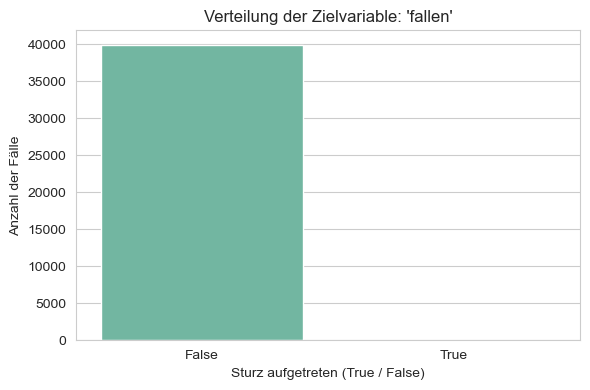

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

# Absolute Häufigkeiten
fall_counts = df["fallen"].value_counts(dropna=False)

# Relative Häufigkeiten in %
fall_percent = df["fallen"].value_counts(normalize=True, dropna=False) * 100

# Tabelle anzeigen
fall_summary = pd.DataFrame({
    "Anzahl": fall_counts,
    "Prozent": fall_percent.round(2)
})

print("📊 Verteilung der Zielvariable 'fallen':")
print(fall_summary)

# Balkendiagramm
# Balkendiagramm ohne FutureWarning
plt.figure(figsize=(6, 4))
sns.barplot(
    x=fall_counts.index.astype(str),
    y=fall_counts.values,
    hue=fall_counts.index.astype(str),  # Dummy Hue
    palette="Set2",
    legend=False
)
plt.title("Verteilung der Zielvariable: 'fallen'")
plt.xlabel("Sturz aufgetreten (True / False)")
plt.ylabel("Anzahl der Fälle")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

# -> Highly imbalanced target variable will need special Sampling.


C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\165548051.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_table.iloc[:20, 0], y=missing_table.iloc[:20].index, palette="viridis")


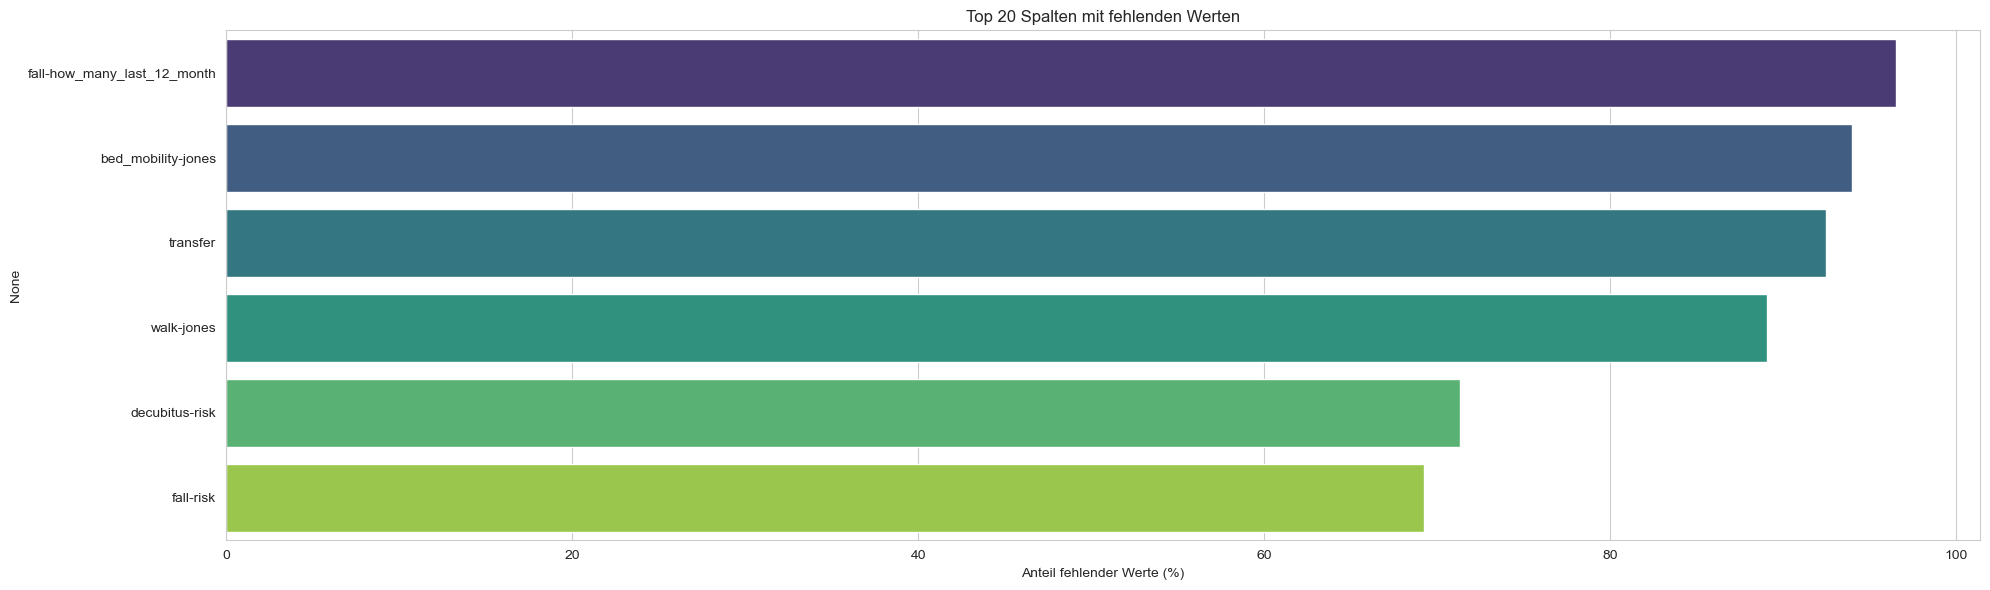

,Missing (%)
fall-how_many_last_12_month,96.536201
bed_mobility-jones,93.985244
transfer,92.484682
walk-jones,89.078404
decubitus-risk,71.289233
fall-risk,69.203451


In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fehlende Werte pro Spalte in Prozent
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
missing_table = missing_percent[missing_percent > 0].to_frame(name="Missing (%)")

# Balkendiagramm der Top 20 Spalten mit fehlenden Werten
plt.figure(figsize=(20, 6))
sns.barplot(x=missing_table.iloc[:20, 0], y=missing_table.iloc[:20].index, palette="viridis")
plt.xlabel("Anteil fehlender Werte (%)")
plt.title("Top 20 Spalten mit fehlenden Werten")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

# Tabelle optional anzeigen
display(missing_table)



📊 Übersicht für Spalte: fall-how_many_last_12_month
--------------------------------------------------
🔹 Fehlende Werte: 96.54 %
🔹 Anzahl unterschiedlicher Werte (inkl. NaN): 5

🔸 Wertverteilung:
fall-how_many_last_12_month
<NA>    38600
1        1122
5         249
3          11
2           3
Name: count, dtype: Int64

📊 Übersicht für Spalte: bed_mobility-jones
--------------------------------------------------
🔹 Fehlende Werte: 93.99 %
🔹 Anzahl unterschiedlicher Werte (inkl. NaN): 6

🔸 Wertverteilung:
bed_mobility-jones
NaN    37580
2       1678
3        494
4A       139
1         89
4B         5
Name: count, dtype: int64

📊 Übersicht für Spalte: walk-jones
--------------------------------------------------
🔹 Fehlende Werte: 89.08 %
🔹 Anzahl unterschiedlicher Werte (inkl. NaN): 6

🔸 Wertverteilung:
walk-jones
NaN    35618
2       3084
3        486
1        483
4A       241
4B        73
Name: count, dtype: int64

📊 Übersicht für Spalte: decubitus-risk
---------------------------------

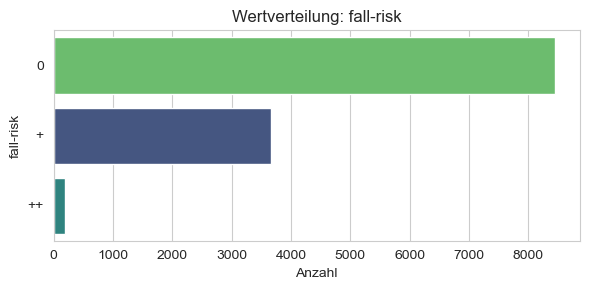

In [189]:
 # 2. Flag Missing Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stil für Diagramme
sns.set_style("whitegrid")

# Zielspalten laut deiner Analyse
columns_to_check = [
    "fall-how_many_last_12_month",
    "bed_mobility-jones",
    "walk-jones",
    "decubitus-risk",
    "fall-risk"
]

# Analyse-Schleife
for col in columns_to_check:
    print(f"\n📊 Übersicht für Spalte: {col}")
    print("-" * 50)
    
    # Fehlende Werte
    missing_pct = df[col].isna().mean() * 100
    print(f"🔹 Fehlende Werte: {missing_pct:.2f} %")

    # Anzahl eindeutiger Werte inkl. NaN
    unique_vals = df[col].nunique(dropna=False)
    print(f"🔹 Anzahl unterschiedlicher Werte (inkl. NaN): {unique_vals}")

    # Verteilung (inkl. NaN)
    print("\n🔸 Wertverteilung:")
    print(df[col].value_counts(dropna=False))

    # Visualisierung für kategoriale Merkmale
   # Visualisierung für kategoriale Merkmale (warnungsfrei)
if df[col].dtype.name == "category":
    plt.figure(figsize=(6, 3))
    sns.countplot(
        data=df,
        y=col,
        order=df[col].value_counts().index,
        hue=col,                  # dummy hue notwendig für palette
        palette="viridis",
        legend=False              # keine doppelte Legende nötig
    )
    plt.title(f"Wertverteilung: {col}")
    plt.xlabel("Anzahl")
    plt.tight_layout()
    plt.show()


In [190]:
# Entfernen der ID-Spalte, da sie keine nützliche Information enthält
if "id" in df.columns:
    df.drop(columns="id", inplace=True)
    print("🗑️ Spalte 'id' wurde entfernt (nur Identifikator, keine Modellrelevanz).")


🗑️ Spalte 'id' wurde entfernt (nur Identifikator, keine Modellrelevanz).


In [191]:
# 1. Numerisch: NaN mit 0 ersetzen
# Neue Spalte: Angabe vorhanden oder nicht
df["fall-how_many_last_12_month_present"] = df["fall-how_many_last_12_month"].notna()

# NaNs durch 0 ersetzen
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].fillna(0).astype("int64")

# 2. Kategorisch: NaN mit "unknown" ersetzen
columns_to_fill_unknown = [
    "bed_mobility-jones",
    "walk-jones",
    "transfer",
    "decubitus-risk",
    "fall-risk"
]

for col in columns_to_fill_unknown:
    df[col] = df[col].cat.add_categories("unknown")  # Kategorie "unknown" hinzufügena
    df[col] = df[col].fillna("unknown")              # NaN ersetzen


In [192]:
#import sweetviz as sv

# Generate a Sweetviz report
#report = sv.analyze(df)

# Display the report in the notebook
#report.show_html("sweetviz_report.html")


In [193]:
# 📊 Übersicht über den Datensatz
print("📊 Intuitive Summary of Dataset:")
print(f"Anzahl Zeilen: {len(df)}")
print(f"Anzahl Spalten: {df.shape[1]}")
print("\n🔹 Spalten nach Datentyp:")
print(df.dtypes.value_counts())
print("\n🔹 Anteil fehlender Werte (Top 10):")
print((df.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))


📊 Intuitive Summary of Dataset:
Anzahl Zeilen: 39985
Anzahl Spalten: 44

🔹 Spalten nach Datentyp:
bool        20
boolean     14
category     3
int64        2
category     2
category     1
category     1
category     1
Name: count, dtype: int64

🔹 Anteil fehlender Werte (Top 10):
fallen                            0.0
age                               0.0
fall-while_transfer               0.0
walk-impairment                   0.0
walk-jones                        0.0
walk-balance_and_gait_impaired    0.0
walking_aid                       0.0
excretions-impairment             0.0
excretions-incontinence           0.0
excretions-nykturie               0.0
dtype: float64



📈 Ausreißeranalyse für: age
Q1: 39.00
Q3: 74.00
IQR: 35.00
Lower Bound: -13.50
Upper Bound: 126.50
Anzahl Ausreißer: 0 (0.00%)


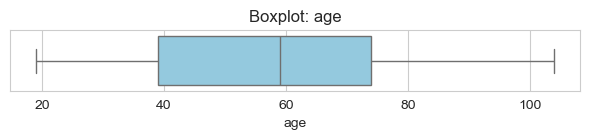


📈 Ausreißeranalyse für: fall-how_many_last_12_month
Q1: 0.00
Q3: 0.00
IQR: 0.00
Lower Bound: 0.00
Upper Bound: 0.00
Anzahl Ausreißer: 1385 (3.46%)


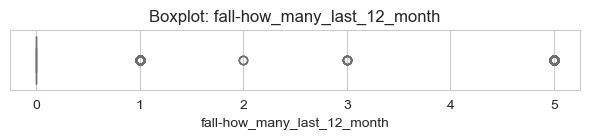

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔍 Ausreißeranalyse mit IQR
for col in ["age","fall-how_many_last_12_month"]:
    if col in df.columns:
        print(f"\n📈 Ausreißeranalyse für: {col}")
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"Q1: {Q1:.2f}")
        print(f"Q3: {Q3:.2f}")
        print(f"IQR: {IQR:.2f}")
        print(f"Lower Bound: {lower_bound:.2f}")
        print(f"Upper Bound: {upper_bound:.2f}")
        print(f"Anzahl Ausreißer: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

        # 📦 Boxplot anzeigen
        plt.figure(figsize=(6, 1.5))
        sns.boxplot(x=df[col], color="skyblue")
        plt.title(f"Boxplot: {col}")
        plt.tight_layout()
        plt.show()


In [195]:
# Crosstab mit relativen Häufigkeiten (Zeilenprozent)
def show_crosstab(col):
    print(f"\n📊 Verteilung von 'fallen' je Kategorie in: {col}")
    ct = pd.crosstab(df[col], df["fallen"], normalize="index") * 100
    display(ct.round(2))

# Analyse für ausgewählte kategoriale Merkmale
for cat_col in ["fall-risk", "decubitus-risk", "walk-jones", "bed_mobility-jones"]:
    if cat_col in df.columns:
        show_crosstab(cat_col)



📊 Verteilung von 'fallen' je Kategorie in: fall-risk


fallen,False,True
fall-risk,,
+,97.44,2.56
++,100.00,0.00
0,100.00,0.00
unknown,100.00,0.00



📊 Verteilung von 'fallen' je Kategorie in: decubitus-risk


fallen,False,True
decubitus-risk,,
+,97.81,2.19
++,97.70,2.30
0,99.90,0.10
unknown,99.92,0.08



📊 Verteilung von 'fallen' je Kategorie in: walk-jones


fallen,False,True
walk-jones,,
1,93.58,6.42
2,99.90,0.10
3,97.53,2.47
4A,96.27,3.73
4B,95.89,4.11
unknown,99.90,0.10



📊 Verteilung von 'fallen' je Kategorie in: bed_mobility-jones


fallen,False,True
bed_mobility-jones,,
1,93.26,6.74
2,99.88,0.12
3,97.17,2.83
4A,95.68,4.32
4B,100.00,0.00
unknown,99.82,0.18


Die ordinalen Merkmale `fall-risk`, `decubitus-risk`, `walk-jones` und `bed_mobility-jones` wurden anhand einer logisch definierten Skala in numerische Werte umgewandelt. 
Werte mit "unknown" wurden als -1 codiert, um sie im Modell als unbekannt, aber explizit markiert, zu belassen.


In [196]:
# 🧠 Ziel: Ordinale Features mit Mapping umwandeln, dabei unbekannte Werte ("unknown" oder ungemappte Werte) als -1 behandeln

ordinal_mappings = {
    "fall-risk": {
        "unknown": -1,
        "0": 0,
        "+": 1,
        "++": 2
    },
    "decubitus-risk": {
        "unknown": -1,
        "0": 0,
        "+": 1,
        "++": 2
    },
    "walk-jones": {
        "unknown": -1,
        "1": 1,
        "2": 2,
        "3": 3,
        "4A": 4
    },
    "bed_mobility-jones": {
        "unknown": -1,
        "1": 1,
        "2": 2,
        "3": 3,
        "4A": 4
    }
}

# ✅ Mapping mit Fehlervermeidung durch fillna(-1)
for col, mapping in ordinal_mappings.items():
    print(f"🔁 Mapping Spalte '{col}' mit: {mapping}")
    df[col] = df[col].map(mapping).fillna(-1).astype("int64")
    print(f"✅ '{col}' erfolgreich konvertiert: dtype = {df[col].dtype}\n")


🔁 Mapping Spalte 'fall-risk' mit: {'unknown': -1, '0': 0, '+': 1, '++': 2}
✅ 'fall-risk' erfolgreich konvertiert: dtype = int64

🔁 Mapping Spalte 'decubitus-risk' mit: {'unknown': -1, '0': 0, '+': 1, '++': 2}
✅ 'decubitus-risk' erfolgreich konvertiert: dtype = int64

🔁 Mapping Spalte 'walk-jones' mit: {'unknown': -1, '1': 1, '2': 2, '3': 3, '4A': 4}
✅ 'walk-jones' erfolgreich konvertiert: dtype = int64

🔁 Mapping Spalte 'bed_mobility-jones' mit: {'unknown': -1, '1': 1, '2': 2, '3': 3, '4A': 4}
✅ 'bed_mobility-jones' erfolgreich konvertiert: dtype = int64



In [197]:
# Optional: Korrektheit prüfen
df[list(ordinal_mappings.keys())].describe()


,fall-risk,decubitus-risk,walk-jones,bed_mobility-jones
count,39985.000000,39985.000000,39985.000000,39985.000000
mean,-0.590371,-0.627710,-0.665700,-0.802851
std,0.674555,0.659186,0.987877,0.795189
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000
75%,0.000000,0.000000,-1.000000,-1.000000
max,2.000000,2.000000,4.000000,4.000000


In [198]:
#import sweetviz as sv

# Generate a Sweetviz report
#report = sv.analyze(df)

# Display the report in the notebook
#report.show_html("sweetviz_report.html")


In [199]:
# 🔎 Schritt 1: Fallrate pro Procedure-Kategorie berechnen
procedure_fall_rate = df.groupby("procedure")["fallen"].mean()

# 🧾 Optional: Ausgabe der Top/Bottom Prozeduren
print("📈 Prozeduren mit höchster Fallrate:")
print(procedure_fall_rate.sort_values(ascending=False).head())

print("\n📉 Prozeduren mit niedrigster Fallrate:")
print(procedure_fall_rate.sort_values().head())

# 📌 Schritt 2: Neues numerisches Feature erstellen (Fallrate wird gemappt)
df["procedure_fallrate"] = df["procedure"].map(procedure_fall_rate)

# 🧼 Schritt 3: Originalspalte 'procedure' entfernen, falls nicht mehr gebraucht
df = df.drop(columns="procedure")

# ✅ Ergebnis prüfen
print("\n✅ Neues Feature 'procedure_fallrate' erstellt – Beispielwerte:")
print(df[["procedure_fallrate", "fallen"]].head())


📈 Prozeduren mit höchster Fallrate:
procedure
3-22    0.048387
1-85    0.036364
5-65    0.035714
5-80    0.030303
5-90    0.028169
Name: fallen, dtype: float64

📉 Prozeduren mit niedrigster Fallrate:
procedure
0       0.0
5-56    0.0
5-58    0.0
5-59    0.0
5-61    0.0
Name: fallen, dtype: float64

✅ Neues Feature 'procedure_fallrate' erstellt – Beispielwerte:
   procedure_fallrate  fallen
0            0.000000   False
1            0.000000   False
2            0.021127   False
3            0.000000   False
4            0.000000   False


C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\354958058.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  procedure_fall_rate = df.groupby("procedure")["fallen"].mean()


In [200]:
# Achtung: Braucht ggf. openpyxl installiert → pip install openpyxl
df.to_excel("kip_sdm_cleaned.xlsx", index=False)


Da  ein unausgewogenes Target (fallen):
Verwenden eines stratifizierten Split, um sicherzustellen, dass die Verteilung von fallen in train und test ähnlich ist.



In [201]:
# Installiere imbalanced-learn, falls noch nicht vorhanden
#!pip install imbalanced-learn


In [202]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# 🎯 Zielvariable
target = "fallen"

# 📦 Features und Target aufteilen
X = df.drop(columns=target)
y = df[target]

# ✂️ Stratified Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 🔎 Verteilungen vor dem Oversampling überprüfen
print("📊 Verteilung im gesamten Datensatz:")
print(y.value_counts(normalize=True) * 100)

print("\n📊 Verteilung im Trainingsset (vor Oversampling):")
print(y_train.value_counts(normalize=True) * 100)

print("\n📊 Verteilung im Testset:")
print(y_test.value_counts(normalize=True) * 100)

# 🔄 Oversampling (nur auf Trainingsdaten!)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# ✅ Ergebnis nach Oversampling
print("\n✅ Verteilung im Trainingsset (nach Oversampling):")
print(y_train_resampled.value_counts(normalize=True) * 100)


📊 Verteilung im gesamten Datensatz:
fallen
False    99.764912
True      0.235088
Name: proportion, dtype: float64

📊 Verteilung im Trainingsset (vor Oversampling):
fallen
False    99.765537
True      0.234463
Name: proportion, dtype: float64

📊 Verteilung im Testset:
fallen
False    99.762411
True      0.237589
Name: proportion, dtype: float64

✅ Verteilung im Trainingsset (nach Oversampling):
fallen
False    50.0
True     50.0
Name: proportion, dtype: float64


In [203]:
"""
# Korrelationen mit der Zielvariable 'fallen', sortiert
fallen_corr = corr_matrix["fallen"].drop("fallen").sort_values(ascending=False)

# Nur die Top-N stärksten Korrelationen anzeigen
top_n = 15
top_corr_vars = fallen_corr.abs().sort_values(ascending=False).head(top_n).index

# Heatmap der Top-Korrelationen mit 'fallen'
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix.loc[top_corr_vars, ["fallen"]],
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=False
)
plt.title("Stärkste Korrelationen mit Zielvariable 'fallen'")

plt.tight_layout()
plt.show()
"""

'\n# Korrelationen mit der Zielvariable \'fallen\', sortiert\nfallen_corr = corr_matrix["fallen"].drop("fallen").sort_values(ascending=False)\n\n# Nur die Top-N stärksten Korrelationen anzeigen\ntop_n = 15\ntop_corr_vars = fallen_corr.abs().sort_values(ascending=False).head(top_n).index\n\n# Heatmap der Top-Korrelationen mit \'fallen\'\nplt.figure(figsize=(8, 6))\nsns.heatmap(\n    corr_matrix.loc[top_corr_vars, ["fallen"]],\n    annot=True,\n    cmap="coolwarm",\n    fmt=".2f",\n    cbar=False\n)\nplt.title("Stärkste Korrelationen mit Zielvariable \'fallen\'")\n\nplt.tight_layout()\nplt.show()\n'

In [204]:
'''import sweetviz as sv

# Generate a Sweetviz report
report = sv.analyze(df)

# Display the report in the notebook
report.show_html("sweetviz_report.html")
'''

'import sweetviz as sv\n\n# Generate a Sweetviz report\nreport = sv.analyze(df)\n\n# Display the report in the notebook\nreport.show_html("sweetviz_report.html")\n'

In [205]:
# Konstanten-Spalten (nur ein einziger Wert) automatisch identifizieren und entfernen
n_unique = df.nunique()
constant_cols = n_unique[n_unique <= 1].index.tolist()

print("🗑️ Entfernte Spalten (konstant):", constant_cols)
df = df.drop(columns=constant_cols)


🗑️ Entfernte Spalten (konstant): ['medical_items-A_V_system']


In [206]:
# Neue Spalte: True, wenn Transfer "unknown", sonst False
df["transfer_unknown"] = df["transfer"].astype(str).str.lower() == "unknown"


In [207]:
# 📦 Import falls noch nicht erfolgt
import pandas as pd

# 1️⃣ Optional: Fallrate pro Diagnose berechnen (zum Explorieren, nicht zwingend notwendig für die Reduktion)
fallrate_by_diag = df.groupby("diagnosis", observed=False)["fallen"].mean().sort_values(ascending=False)
print("📊 Diagnosen mit höchster Fallrate:")
print(fallrate_by_diag.head())

# 2️⃣ Die häufigsten Diagnosen (Top-N) behalten – alle anderen als 'other' gruppieren
top_n = 20  # oder 30, je nach Bedarf
top_diag = df["diagnosis"].value_counts().nlargest(top_n).index

# 3️⃣ Diagnose-Spalte in Kategorie umwandeln (falls noch nicht)
df["diagnosis"] = df["diagnosis"].astype("category")

# 4️⃣ Kategorie 'other' hinzufügen, falls sie noch nicht existiert
if "other" not in df["diagnosis"].cat.categories:
    df["diagnosis"] = df["diagnosis"].cat.add_categories("other")

# 5️⃣ Neue Spalte: häufige Diagnosen beibehalten, andere → "other"
df["diagnosis_reduced"] = df["diagnosis"].where(df["diagnosis"].isin(top_diag), other="other")

# 6️⃣ Optional: Originalspalte löschen, falls nicht mehr benötigt
# df.drop(columns=["diagnosis"], inplace=True)

# 🖼️ Kontrollausgabe
print("✅ Neue Diagnose-Feature 'diagnosis_reduced' erstellt – Beispiel:")
print(df[["diagnosis", "diagnosis_reduced"]].head(10))


📊 Diagnosen mit höchster Fallrate:
diagnosis
S621    0.333333
N434    0.250000
E160    0.200000
Z450    0.200000
M706    0.200000
Name: fallen, dtype: float64
✅ Neue Diagnose-Feature 'diagnosis_reduced' erstellt – Beispiel:
  diagnosis diagnosis_reduced
0      S250             other
1      M418             other
2      S910             other
3      M400             other
4      K630             other
5      B342             other
6      I714             other
7      J988             other
8      I639             other
9      B350             other


In [208]:
# 📊 Durchschnittliche Sturzrate pro Diagnose berechnen
fallrate_by_diag = df.groupby("diagnosis")["fallen"].mean()

# 🧠 Neues numerisches Feature erstellen
df["diagnosis_fallrate"] = df["diagnosis"].map(fallrate_by_diag)

# 📌 Kontrollausgabe: Top-Diagnosen nach Fallrate
print("📈 Diagnosen mit höchster Fallrate:")
print(fallrate_by_diag.sort_values(ascending=False).head(10))

# ✅ Beispielausgabe zur Kontrolle
print("\n✅ Neues Feature 'diagnosis_fallrate' erstellt – Beispiel:")
display(df[["diagnosis", "diagnosis_fallrate"]].head())


📈 Diagnosen mit höchster Fallrate:
diagnosis
S621    0.333333
N434    0.250000
E160    0.200000
Z450    0.200000
M706    0.200000
I249    0.200000
S508    0.200000
O140    0.200000
T838    0.166667
N930    0.166667
Name: fallen, dtype: float64

✅ Neues Feature 'diagnosis_fallrate' erstellt – Beispiel:


C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\1309389182.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fallrate_by_diag = df.groupby("diagnosis")["fallen"].mean()


,diagnosis,diagnosis_fallrate
0,S250,0.0
1,M418,0.0
2,S910,0.0
3,M400,0.0
4,K630,0.0


In [209]:
# 📊 Durchschnittliche Sturzrate pro 'diagnosis_reduced' berechnen
fallrate_by_diag_reduced = df.groupby("diagnosis_reduced")["fallen"].mean()

# ➕ Numerisches Feature: mittlere Fallrate pro reduzierte Diagnose
df["diagnosis_reduced_fallrate"] = df["diagnosis_reduced"].map(fallrate_by_diag_reduced)

# 🖼️ Kontrollausgabe
print("📈 Durchschnittliche Fallraten pro 'diagnosis_reduced':")
print(fallrate_by_diag_reduced.sort_values(ascending=False))

print("\n✅ Beispielwerte:")
display(df[["diagnosis", "diagnosis_reduced", "diagnosis_reduced_fallrate"]].head())


📈 Durchschnittliche Fallraten pro 'diagnosis_reduced':
diagnosis_reduced
A152    0.016393
A099    0.013699
A090    0.012987
A014    0.004167
0       0.003643
          ...   
Z965         NaN
Z966         NaN
Z978         NaN
Z981         NaN
Z990         NaN
Name: fallen, Length: 3346, dtype: float64

✅ Beispielwerte:


C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\2367179733.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fallrate_by_diag_reduced = df.groupby("diagnosis_reduced")["fallen"].mean()


,diagnosis,diagnosis_reduced,diagnosis_reduced_fallrate
0,S250,other,0.002316
1,M418,other,0.002316
2,S910,other,0.002316
3,M400,other,0.002316
4,K630,other,0.002316


In [210]:
from scipy.stats import spearmanr

# 🧪 Spearman-Korrelation berechnen
corr, p_value = spearmanr(df["diagnosis_reduced_fallrate"], df["fallen"])

# 📊 Ergebnis anzeigen
print(f"📈 Spearman-Korrelation: {corr:.4f}")
print(f"📌 p-Wert: {p_value:.4e}")

# Interpretation (optional)
if p_value < 0.05:
    print("✅ Statistisch signifikante Korrelation (p < 0.05)")
else:
    print("⚠️ Keine signifikante Korrelation (p ≥ 0.05)")


📈 Spearman-Korrelation: 0.0136
📌 p-Wert: 6.5574e-03
✅ Statistisch signifikante Korrelation (p < 0.05)


C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\4058500559.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='fall-risk', y='age', palette='coolwarm')
c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


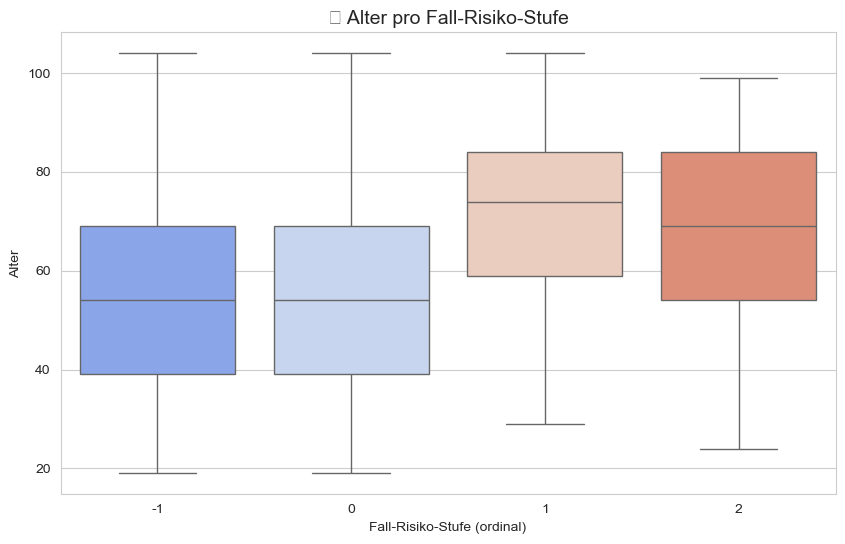

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='fall-risk', y='age', palette='coolwarm')
plt.title("📊 Alter pro Fall-Risiko-Stufe", fontsize=14)
plt.xlabel("Fall-Risiko-Stufe (ordinal)")
plt.ylabel("Alter")
plt.grid(True, axis='y')
plt.show()


C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\197913375.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_fallrate.values, y=group_fallrate.index, palette="coolwarm")
C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\197913375.py:16: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Veit\anaconda3\envs\aa_tuesday\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


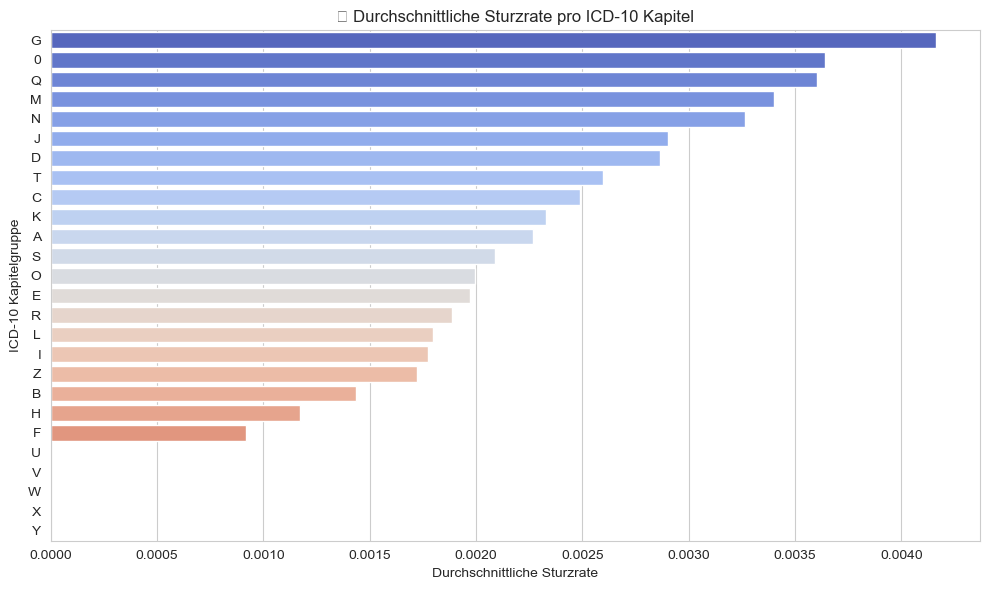

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🧾 ICD-10 Kapitelgruppierung (nur erstes Zeichen)
df["diagnosis_group"] = df["diagnosis"].astype(str).str[0]

# 📊 Sturzrate pro Gruppe berechnen
group_fallrate = df.groupby("diagnosis_group")["fallen"].mean().sort_values(ascending=False)

# 📈 Visualisieren
plt.figure(figsize=(10, 6))
sns.barplot(x=group_fallrate.values, y=group_fallrate.index, palette="coolwarm")
plt.xlabel("Durchschnittliche Sturzrate")
plt.ylabel("ICD-10 Kapitelgruppe")
plt.title("🏥 Durchschnittliche Sturzrate pro ICD-10 Kapitel")
plt.tight_layout()
plt.show()


In [213]:
# Bereits geschehen:
df["diagnosis_group"] = df["diagnosis"].astype(str).str[0]


In [214]:
# Diagnose-Spalte entfernen (nachdem diagnosis_group abgeleitet wurde)
df.drop(columns=["diagnosis"], inplace=True)


As decision trees as well as SHAP Values can only handle numerical values, we need to transform the data.

In [215]:
from sklearn.preprocessing import LabelEncoder

# Step 2: Handle categorical columns
categorical_columns = df.select_dtypes(include=['category']).columns
print("\nCategorical columns:", categorical_columns)

label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Step 3: Handle object columns
object_columns = df.select_dtypes(include=['object']).columns
print("\nObject columns:", object_columns)

for col in object_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Step 4: Handle boolean columns
boolean_columns = df.select_dtypes(include=['bool']).columns
print("\nBoolean columns:", boolean_columns)

for col in boolean_columns:
    df[col] = df[col].astype(int)



Categorical columns: Index(['transfer', 'sex', 'diagnosis_reduced'], dtype='object')

Object columns: Index(['diagnosis_group'], dtype='object')

Boolean columns: Index(['fallen', 'c_zriserh1', 'decubitus-at_the_moment',
       'bed_mobility-impairment', 'bed_mobility-skin_condition',
       'transfer-impairment', 'medical_items',
       'medical_items-arm_or_leg_splint',
       'medical_items-plaster_or_neck_brace',
       'medical_items-compression_stocking', 'medical_items-ventilation_mask',
       'medical_items-O2_glasses', 'medical_items-orthesis',
       'medical_items-prosthesis',
       'medical_items-skin_condition_at_item_application',
       'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer',
       'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid',
       'excretions-impairment', 'excretions-incontinence',
       'excretions-nykturie', 'cognition-impairment',
       'cognition-disoriented_time', 'cognition-disoriented_location',
       'cognit

## Section 3
### a) A simple, interpretable model - Decision Tree

In [216]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


# Step 5: Split the data
# Assuming the target column is named 'fallen'
target = 'fallen'  # Replace with the actual target column name
X = df.drop(columns=[target])
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Define hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Test different tree depths
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10]  # Minimum samples at a leaf node
}

# Step 7: Perform Grid Search with Cross-Validation
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 8: Train the best model
best_clf = grid_search.best_estimator_

# Step 9: Evaluate the model
y_pred = best_clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 10: Print the best hyperparameters
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7978
           1       0.82      0.95      0.88        19

    accuracy                           1.00      7997
   macro avg       0.91      0.97      0.94      7997
weighted avg       1.00      1.00      1.00      7997


Best Hyperparameters:
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


Also, Oversampling is not needed; Class weight balancing is solved in step 6, parameter class_weight='balanced'

Also, hyperparameter tuning has been automatized in order to find the best hyperparameters (max_depth; min_samples_split; min_samples_leaf) for the model.

In [217]:
from sklearn.tree import export_text

# Step 5: Visualize the Decision Tree (Text-Based)
tree_rules = export_text(best_clf, feature_names=list(X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- walk-balance_and_gait_impaired <= 0.50
|   |--- class: 0
|--- walk-balance_and_gait_impaired >  0.50
|   |--- diagnosis_fallrate <= 0.00
|   |   |--- procedure_fallrate <= 0.00
|   |   |   |--- class: 0
|   |   |--- procedure_fallrate >  0.00
|   |   |   |--- class: 0
|   |--- diagnosis_fallrate >  0.00
|   |   |--- procedure_fallrate <= 0.00
|   |   |   |--- class: 0
|   |   |--- procedure_fallrate >  0.00
|   |   |   |--- age <= 41.50
|   |   |   |   |--- class: 0
|   |   |   |--- age >  41.50
|   |   |   |   |--- diagnosis_fallrate <= 0.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- diagnosis_fallrate >  0.00
|   |   |   |   |   |--- class: 1



#### interpretability techniques 

It can be seen that the variable 'fall' is predicted if walk-balance_and_gait_impaired is true (the Boolean variable was previously converted to an integer (0, 1)), the fall rate of the respective diagnosis and also the treatment is > 0 and the age of the respective person is > 41.5 years.

### b) A mjore complex model - Using the model having the best F1-Score trained with Autogluon

First, the data gets prepared using Oversampling in order to train the models on a dataset having equal amount of data with an outcome fallen = True and fallen = 1.

In [ ]:
# reuse data stored in temporary variable earlier
# df = df_for_complex_model

In [219]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# 🎯 Zielvariable
target = "fallen"

# 📦 Features und Target aufteilen
X = df.drop(columns=target)
y = df[target]

# ✂️ Stratified Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 🔎 Verteilungen vor dem Oversampling überprüfen
print("📊 Verteilung im gesamten Datensatz:")
print(y.value_counts(normalize=True) * 100)

print("\n📊 Verteilung im Trainingsset (vor Oversampling):")
print(y_train.value_counts(normalize=True) * 100)

print("\n📊 Verteilung im Testset:")
print(y_test.value_counts(normalize=True) * 100)

# 🔄 Oversampling (nur auf Trainingsdaten!)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# ✅ Ergebnis nach Oversampling
print("\n✅ Verteilung im Trainingsset (nach Oversampling):")
print(y_train_resampled.value_counts(normalize=True) * 100)


📊 Verteilung im gesamten Datensatz:
fallen
0    99.764912
1     0.235088
Name: proportion, dtype: float64

📊 Verteilung im Trainingsset (vor Oversampling):
fallen
0    99.765537
1     0.234463
Name: proportion, dtype: float64

📊 Verteilung im Testset:
fallen
0    99.762411
1     0.237589
Name: proportion, dtype: float64

✅ Verteilung im Trainingsset (nach Oversampling):
fallen
0    50.0
1    50.0
Name: proportion, dtype: float64


Now we start automated model training using Autogluon and the prepared dataset

In [223]:
from autogluon.tabular import TabularPredictor
import pandas as pd

# Step 1: Combine X_train_resampled and y_train_resampled into a single DataFrame
train_data_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
train_data_resampled.columns = list(X_train_resampled.columns) + [target]  # Ensure target column is named correctly

# Step 2: Combine X_test and y_test into a single DataFrame for evaluation
test_data = pd.concat([X_test, y_test], axis=1)
test_data.columns = list(X_test.columns) + [target]  # Ensure target column is named correctly

# Step 3: Train AutoGluon using the resampled training data
predictor = TabularPredictor(label=target, eval_metric="f1", verbosity=2).fit(
    train_data=train_data_resampled,
    time_limit=600  # Adjust time limit as needed
)

# Step 4: Display the leaderboard using the test data
leaderboard = predictor.leaderboard(test_data, silent=False)

No path specified. Models will be saved in: "AutogluonModels\ag-20250327_212716"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.21
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          24
Memory Avail:       14.54 GB / 31.92 GB (45.6%)
Disk Space Avail:   97.94 GB / 931.51 GB (10.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         

                  model  score_test  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        NeuralNetTorch    0.926829   1.000000          f1        0.060001       0.016246  25.609148                 0.060001                0.016246          25.609148            1       True         12
1              CatBoost    0.904762   1.000000          f1        0.015998       0.001999   5.883399                 0.015998                0.001999           5.883399            1       True          7
2              LightGBM    0.878049   1.000000          f1        0.013999       0.004996   1.434185                 0.013999                0.004996           1.434185            1       True          4
3            LightGBMXT    0.878049   1.000000          f1        0.014510       0.005002   1.927831                 0.014510                0.005002           1.927831            1   

In [276]:
# Test Feature Importance for target Variable
from autogluon.tabular import TabularPredictor
import pandas as pd

feature_importance_df = predictor.feature_importance(test_data)
feature_importance_df.head(20)


Computing feature importance via permutation shuffling for 46 features using 5000 rows with 5 shuffle sets...
	26.12s	= Expected runtime (5.22s per shuffle set)
	3.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
diagnosis_fallrate,0.560942,0.079165,0.000046,5,0.723943,0.397941
walk-balance_and_gait_impaired,0.530172,0.053554,0.000012,5,0.640442,0.419903
walk-impairment,0.460728,0.042132,0.000008,5,0.547478,0.373978
fall-risk,0.380748,0.083343,0.000259,5,0.552351,0.209144
procedure_fallrate,0.360505,0.177492,0.005242,5,0.725964,-0.004954
fall-while_transfer,0.207980,0.063886,0.000946,5,0.339522,0.076438
transfer-impairment,0.178356,0.059910,0.001322,5,0.301712,0.054999
excretions-incontinence,0.122980,0.035122,0.000718,5,0.195297,0.050664
fall-last_12_month,0.079162,0.028562,0.001724,5,0.137972,0.020351
age,0.056486,0.127819,0.189507,5,0.319668,-0.206696


In [ ]:

# feature importance for XGBoost Model

import pandas as pd

# Step 1: Load the XGBoost model from the predictor
xgboost_model = predictor._trainer.load_model("XGBoost").model

# Step 2: Retrieve feature importance from the raw XGBoost model
booster = xgboost_model.get_booster()
xgboost_feature_importance = booster.get_score(importance_type="weight")  # Use "weight", "gain", or "cover"

# Step 3: Map encoded feature names (f1, f2, ...) to actual feature names
feature_names = predictor.feature_metadata.get_features()  # Get original feature names
feature_mapping = {f"f{i}": name for i, name in enumerate(feature_names)}  # Map f1 -> feature_name

# Replace encoded feature names with actual names
xgboost_feature_importance_mapped = {
    feature_mapping.get(key, key): value for key, value in xgboost_feature_importance.items()
}

# Step 4: Convert feature importance to a DataFrame
xgboost_feature_importance_df = pd.DataFrame({
    'Feature': list(xgboost_feature_importance_mapped.keys()),
    'Importance': list(xgboost_feature_importance_mapped.values())
}).sort_values(by='Importance', ascending=False)

# Step 5: Display the top 20 most important features
print(xgboost_feature_importance_df.head(20))
print(xgboost_feature_importance)

                           Feature  Importance
8               procedure_fallrate        68.0
10              diagnosis_fallrate        56.0
6   walk-balance_and_gait_impaired        50.0
9                diagnosis_reduced        26.0
0                              age        16.0
11                 diagnosis_group         8.0
2          bed_mobility-impairment         6.0
4      bed_mobility-skin_condition         4.0
1          decubitus-at_the_moment         1.0
3               bed_mobility-jones         1.0
5               fall-last_12_month         1.0
7                   decubitus-risk         1.0
{'f0': 16.0, 'f2': 1.0, 'f3': 6.0, 'f4': 1.0, 'f5': 4.0, 'f17': 1.0, 'f23': 50.0, 'f35': 1.0, 'f40': 68.0, 'f42': 26.0, 'f43': 56.0, 'f45': 8.0}


Section 2: Korrelationen analysieren

C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\294755799.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fall_corr.head(10), y=fall_corr.head(10).index, palette="crest")


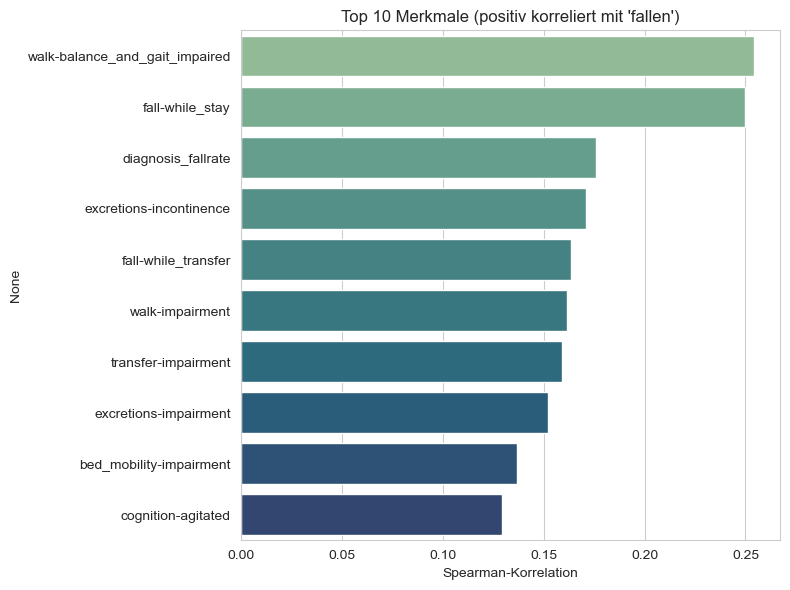

C:\Users\Veit\AppData\Local\Temp\ipykernel_34228\294755799.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fall_corr.tail(10), y=fall_corr.tail(10).index, palette="rocket")


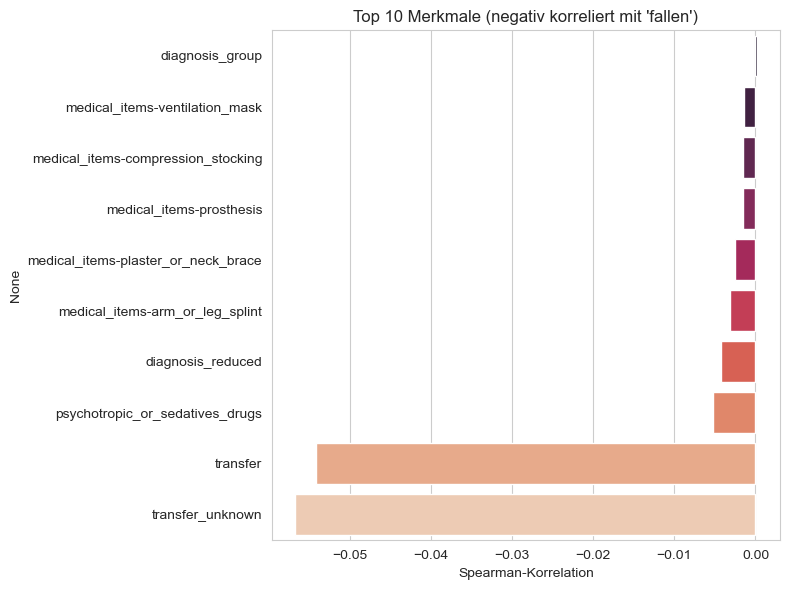

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🔹 1. Nur numerische Features für Korrelationsmatrix (z. B. age, -risk, -jones, fall-how_many)
numerical_cols = df.select_dtypes(include=["int", "float", "Int64"]).columns.tolist()
if "fallen" not in numerical_cols:
    numerical_cols.append("fallen")

corr_matrix = df[numerical_cols].corr(method='spearman')  # robust gegenüber ordinalen Skalen

# 🔍 2. Korrelation mit Zielvariable 'fallen' extrahieren & sortieren
fall_corr = corr_matrix["fallen"].drop("fallen").sort_values(ascending=False)

# 💡 3. Visualisierung: Top 10 positive & negative Korrelationen
plt.figure(figsize=(8, 6))
sns.barplot(x=fall_corr.head(10), y=fall_corr.head(10).index, palette="crest")
plt.title("Top 10 Merkmale (positiv korreliert mit 'fallen')")
plt.xlabel("Spearman-Korrelation")
plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 6))
sns.barplot(x=fall_corr.tail(10), y=fall_corr.tail(10).index, palette="rocket")
plt.title("Top 10 Merkmale (negativ korreliert mit 'fallen')")
plt.xlabel("Spearman-Korrelation")
plt.tight_layout()
plt.show()


#### interpretability techniques - SHAP Values

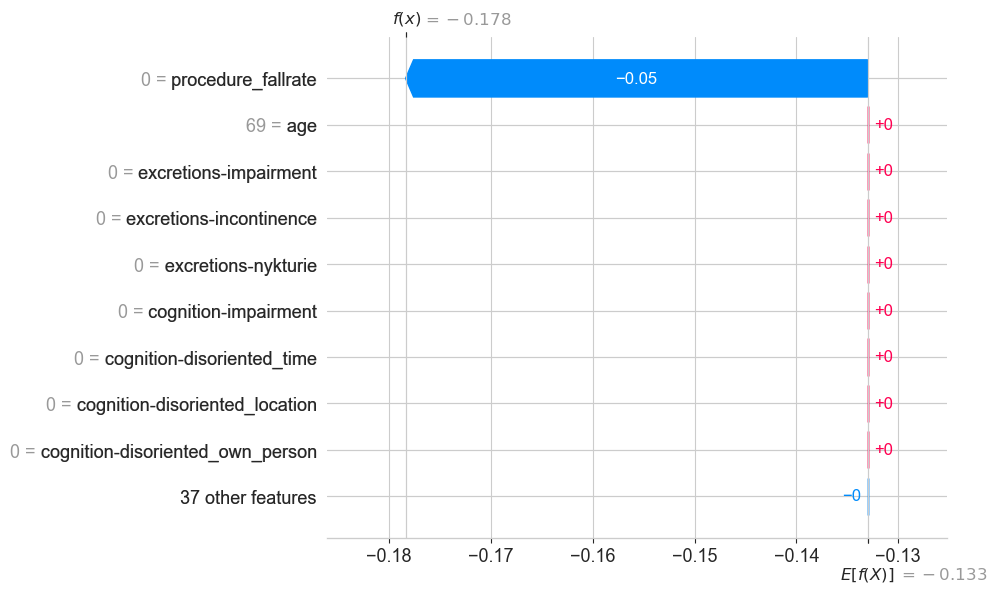

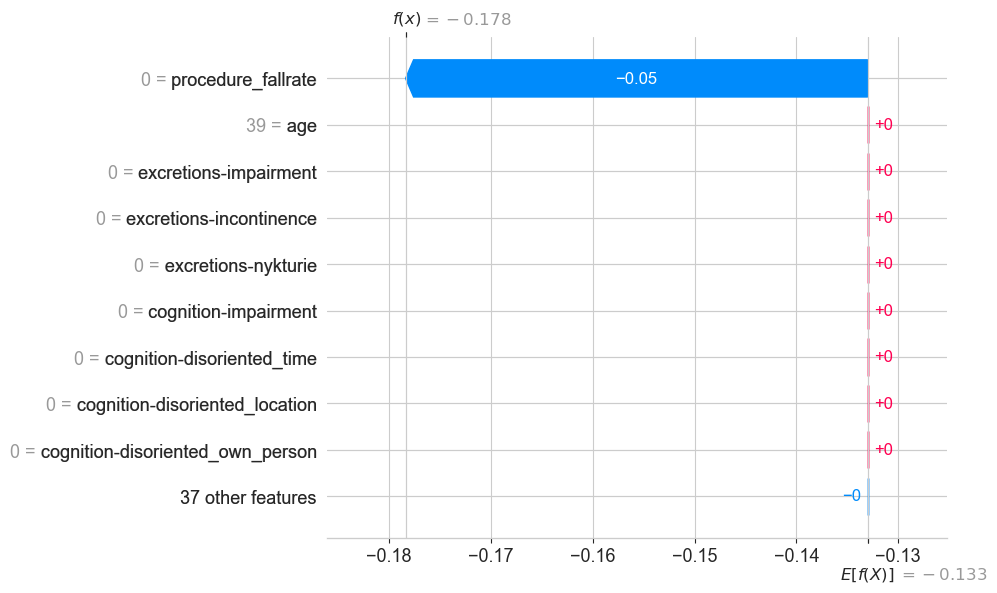

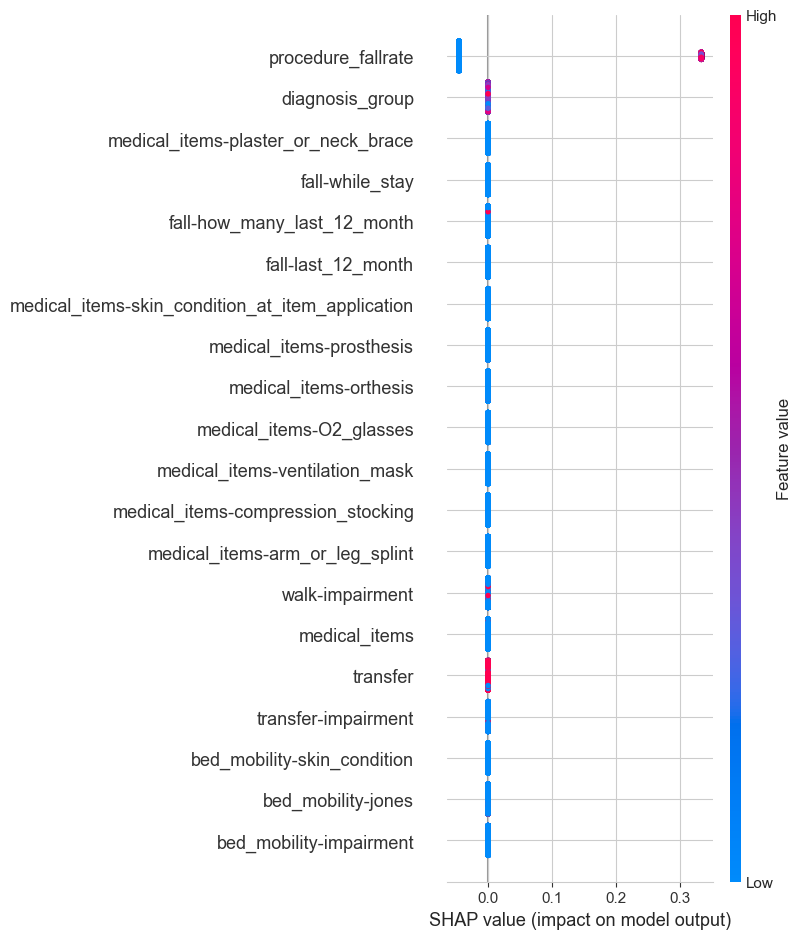

In [297]:
import shap
import matplotlib.pyplot as plt

# Step 1: Extract the XGBoost model from the AutoGluon predictor
xgboost_model = predictor._trainer.load_model('XGBoost').model

# Step 2: Prepare the test data
# Separate features (X_test) and target (y_test)
X_test = test_data.drop(columns=[target])  # Features only
y_test = test_data[target]  # Target variable

# compute SHAP values
explainer = shap.Explainer(xgboost_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])

shap.summary_plot(shap_values, X_test)




In [285]:
print("Distribution of procedure_fallrate:")
print(X_test['procedure_fallrate'].describe())
print("\nDistribution of other features:")
print(X_test.describe())

Distribution of procedure_fallrate:
count    7997.000000
mean        0.002410
std         0.005872
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.048387
Name: procedure_fallrate, dtype: float64

Distribution of other features:
               age   c_zriserh1  decubitus-at_the_moment  \
count  7997.000000  7997.000000              7997.000000   
mean     57.117919     0.158309                 0.002126   
std      19.001329     0.365054                 0.046060   
min      19.000000     0.000000                 0.000000   
25%      39.000000     0.000000                 0.000000   
50%      54.000000     0.000000                 0.000000   
75%      74.000000     0.000000                 0.000000   
max     104.000000     1.000000                 1.000000   

       bed_mobility-impairment  bed_mobility-jones  \
count              7997.000000         7997.000000   
mean                  0.041516           -0.821183   
std                

In [247]:
print(X_test)

       age  c_zriserh1  decubitus-at_the_moment  bed_mobility-impairment  \
15881   69           0                        0                        0   
23533   39           0                        0                        0   
23117   84           0                        0                        0   
6184    79           0                        0                        0   
27790   49           1                        0                        0   
...    ...         ...                      ...                      ...   
35939   29           0                        0                        0   
10528   94           0                        0                        0   
33960   59           0                        0                        0   
8188    39           0                        0                        0   
19898   84           0                        0                        0   

       bed_mobility-jones  bed_mobility-skin_condition  transfer-impairment  \
15881   

In [254]:
print(xgboost_model.predict(X_test.iloc[[4]]))
print(xgboost_model.predict(X_test.iloc[[5]]))

[0]
[1]


In [ ]:
import pandas as pd

# Step 1: Ensure the model and test data are ready
# The trained XGBoost model is already part of the AutoGluon predictor
# X_test is the test set containing the features

# Step 2: Make predictions
predictions = predictor.predict(X_test)  # Predict the "fallen" values for X_test

# Step 3: Combine predictions with test data
# Add the predictions as a new column to the test set
results = X_test.copy()  # Create a copy of X_test to avoid modifying the original
results['fallen_predicted'] = predictions  # Add the predicted values as a new column

# Step 4: Export to CSV
output_file = "predicted_fallen_results.csv"  # Define the output file name
results.to_csv(output_file, index=False)  # Save the DataFrame to a CSV file
print(f"Predictions exported to {output_file}")

Predictions exported to predicted_fallen_results.csv


In [ ]:
import pandas as pd

# Step 1: Ensure the model and test data are ready
# The trained XGBoost model is already part of the AutoGluon predictor
# X_test is the test set containing the features

# Step 2: Make predictions
predictions = predictor.predict(X_test)  # Predict the "fallen" values for X_test

# Step 3: Combine predictions with test data
# Add the predictions as a new column to the test set
results = X_test.copy()  # Create a copy of X_test to avoid modifying the original
results['fallen_predicted'] = predictions  # Add the predicted values as a new column

# Step 4: Export to CSV
output_file = "predicted_fallen_results.csv"  # Define the output file name
results.to_csv(output_file, index=False)  # Save the DataFrame to a CSV file
print(f"Predictions exported to {output_file}")

In [ ]:
import pandas as pd

# Step 1: Ensure the model and test data are ready
# The trained XGBoost model is already part of the AutoGluon predictor
# X_test is the test set containing the features

# Step 2: Make predictions
predictions = predictor.predict(X_test)  # Predict the "fallen" values for X_test

# Step 3: Combine predictions with test data
# Add the predictions as a new column to the test set
results = X_test.copy()  # Create a copy of X_test to avoid modifying the original
results['fallen_predicted'] = predictions  # Add the predicted values as a new column

# Step 4: Join y_test back to the results DataFrame
results['fallen'] = y_test.values  # Add the actual target values as a new column

# Step 5: Export to CSV
output_file = "predicted_fallen_results2.csv"  # Define the output file name
results.to_csv(output_file, index=False)  # Save the DataFrame to a CSV file
print(f"Predictions exported to {output_file}")

Predictions exported to predicted_fallen_results2.csv


In [296]:
import pandas as pd

# Step 1: Ensure the model and test data are ready
# The trained XGBoost model is already part of the AutoGluon predictor
# X_test is the test set containing the features

# Step 2: Make predictions

# Step 3: Combine predictions with test data
# Add the predictions as a new column to the test set
results = X_train.copy()  # Create a copy of X_test to avoid modifying the original

# Step 4: Join y_test back to the results DataFrame
results['fallen'] = y_train.values  # Add the actual target values as a new column

# Step 5: Export to CSV
output_file = "predicted_fallen_results_train.csv"  # Define the output file name
results.to_csv(output_file, index=False)  # Save the DataFrame to a CSV file
print(f"Predictions exported to {output_file}")

Predictions exported to predicted_fallen_results_train.csv


In [293]:
import pandas as pd


# Step 4: Export to CSV
output_file = "df.csv"  # Define the output file name
df.to_csv(output_file, index=False)  # Save the DataFrame to a CSV file
print(f"Predictions exported to {output_file}")

Predictions exported to df.csv


In [262]:
# Print unique values and their counts in the column 'diagnosis_reduced_fallrate'
print("Unique values and their counts in 'diagnosis_reduced_fallrate':")
print(df['diagnosis_reduced_fallrate'].value_counts())

Unique values and their counts in 'diagnosis_reduced_fallrate':
diagnosis_reduced_fallrate
0.002316    36703
0.000000     1249
0.003643     1098
0.002066      484
0.004167      240
0.012987       77
0.013699       73
0.016393       61
Name: count, dtype: int64


In [292]:
# Convert value counts to a DataFrame
procedure_fallrate_counts = df['procedure_fallrate'].value_counts().reset_index()
procedure_fallrate_counts.columns = ['Value', 'Count']

# Print all rows of the DataFrame
print("Unique values and their counts in 'procedure_fallrate':")
print(procedure_fallrate_counts.to_string(index=False))

Unique values and their counts in 'procedure_fallrate':
   Value  Count
0.000000  31782
0.001613    620
0.008475    354
0.003333    300
0.003584    279
0.008547    234
0.004310    232
0.009259    216
0.004651    215
0.015152    198
0.010256    195
0.005155    194
0.005291    189
0.010870    184
0.016949    177
0.017045    176
0.012121    165
0.012270    163
0.012500    160
0.012658    158
0.006452    155
0.006536    153
0.021127    142
0.007143    140
0.014286    140
0.014493    138
0.007407    135
0.007463    134
0.014925    134
0.015873    126
0.016807    119
0.017241    116
0.009009    111
0.018182    110
0.009804    102
0.010309     97
0.010989     91
0.011494     87
0.011765     85
0.011905     84
0.012048     83
0.025000     80
0.025316     79
0.012987     77
0.013158     76
0.013333     75
0.013514     74
0.013699     73
0.027397     73
0.028169     71
0.014706     68
0.030303     66
0.016129     62
0.048387     62
0.016393     61
0.035714     56
0.017857     56
0.036364     55
